# Project task 02: Restaurant recommendation

In [43]:
import scipy.sparse as sp
import numpy as np
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression, Ridge
import time
np.random.seed(158)

The goal of this task is to recommend restaurants to users based on the rating data in the Yelp dataset. For this, we try to predict the rating a user will give to a restaurant they have not been to yet based on a latent factor model.

## 1. Load data

First download `ratings.npy` from Piazza ([download link](https://syncandshare.lrz.de/dl/fiKMoxRNusLoFpFHkXXEgvdZ/ratings.npy)).

In [44]:
ratings = np.load("ratings.npy")

In [45]:
# We have triplets of (user, restaurant, rating).
print(ratings)
users=set(ratings[:,0])
resturants=set(ratings[:,1])
#print(len(np.where(ratings[:,0]==0)[0]))
#for i in (np.where(ratings[:,0]==0)[0]):
#   print(ratings[i])
print(ratings.shape)

[[101968   1880      1]
 [101968    284      5]
 [101968   1378      2]
 ..., 
 [ 72452   2100      4]
 [ 72452   2050      5]
 [ 74861   3979      5]]
(929606, 3)


Now we transform the data into a matrix of dimension [N, D], where N is the number of users and D is the number of restaurants in the dataset.  
We **strongly recommend** to load the data as a sparse matrix to avoid out-of-memory issues.

In [46]:
# Store the matrix into the variable M
#M=sp.csr_matrix(ratings)
M=sp.csr_matrix((ratings[:,2], (ratings[:,0], ratings[:,1])), shape=(len(users), len(resturants)), dtype=np.int64)
####you can remove the shape argument from the call 
### YOUR CODE HERE ###

In [47]:
M

<337867x5899 sparse matrix of type '<class 'numpy.int64'>'
	with 929606 stored elements in Compressed Sparse Row format>

## 2. Preprocess the data

In the preprocessing step, we recursively remove all users and restaurants with 10 or less ratings. 

Then, we randomly select 200 data points for the validation and test sets, respectively.

After this, we subtract the mean rating for each users to account for this global effect.   
**Hint**: Some entries might become zero in this process -- but these entries are different than the 'unknown' zeros in the matrix. Store the indices of which we have data available in a separate variable.

In [48]:
def cold_start_preprocessing(matrix, min_entries):
    """
    Recursively removes rows and columns from the input matrix which have less than min_entries nonzero entries.
    
    Parameters
    ----------
    matrix      : sp.spmatrix, shape [N, D]
                  The input matrix to be preprocessed.
    min_entries : int
                  Minimum number of nonzero elements per row and column.

    Returns
    -------
    matrix      : sp.spmatrix, shape [N', D']
                  The pre-processed matrix, where N' <= N and D' <= D
        
    """
    ### YOUR CODE HERE ###
    if hasattr(cold_start_preprocessing,"count"):
        cold_start_preprocessing.count += 1
    else:
        cold_start_preprocessing.count = 1
    
    if cold_start_preprocessing.count ==1:
        print("Shape before: {}".format(matrix.shape))
    
    
    def drcsr(mat, indices):
        '''Delete Rows CSR: delete rows specified by indices from a CSR Matrix'''
        indices = list(indices)
        mask = np.ones(mat.shape[0], dtype=bool)
        mask[indices] = False
        return mat[mask]

    def dccsr(mat, indices):
        ''' Delete Columns CSR: delete columns specified by indices from a CSR Matrix'''
        indices = list(indices)
        mask = np.ones(mat.shape[1], dtype=bool)
        mask[indices] = False
        return mat[:,mask]
    
    nnz = matrix>0
    col_ind=np.where(nnz.sum(0).A1 <= min_entries)[0]
    matrix=dccsr(matrix, col_ind)
    nnz = matrix>0
    row_ind=np.where(nnz.sum(1).A1 <= min_entries)[0]
    matrix=drcsr(matrix,row_ind)
    nnz = matrix>0
    if (nnz.sum(0).A1 > min_entries).all() != True:
        return cold_start_preprocessing(matrix, min_entries)
    if (nnz.sum(1).A1 > min_entries).all() != True:
        return cold_start_preprocessing(matrix, min_entries)
        
    
    print("Shape after: {}".format(matrix.shape))
    nnz = matrix>0
    assert (nnz.sum(0).A1 > min_entries).all() # sums along the rows, and checks if all entries is > min_entries
    assert (nnz.sum(1).A1 > min_entries).all()
    return matrix

In [49]:
def shift_user_mean(matrix):
    """
    Subtract the mean rating per user from the non-zero elements in the input matrix.
    
    Parameters
    ----------
    matrix : sp.spmatrix, shape [N, D]
             Input sparse matrix.
    Returns
    -------
    matrix : sp.spmatrix, shape [N, D]
             The modified input matrix.
    
    user_means : np.array, shape [N, 1]
                 The mean rating per user that can be used to recover the absolute ratings from the mean-shifted ones.

    """
    
    ### YOUR CODE HERE ###
    sum_cols=matrix.sum(1).A1 #summing the matrix alogn the columns, and flatting the array
    # indptr follwos the relation indptr[i]=indptr[i-1]+ #nnz elements in row (i-1), 
    # so the successive diff is the # of nnz in the i-1 row
    nnz_counts_each_row=np.diff(matrix.indptr)
    #after splitting the data we get rows with 0 sum and 0 nnz elements, this causes nan in division. Avoid these nans
    #by adding 1's where there is no nnz elements to get a final mean of 0
    nnz_counts_each_row[nnz_counts_each_row ==0]=1
    user_means = sum_cols/nnz_counts_each_row
    # copying the orignial matrix, constructing tmp with ones at the same location of matrix
    # constructing a diag sparse matrix using the user_means calculated
    # subtracting the multiplication of diga_mu*tmp (which has now the mean values at the same indices as the 'matrix') 
    # from 'matrix'
    tmp= matrix.copy()
    tmp.data= np.ones_like(tmp.data)
    diag_mu=sp.diags(user_means,0)
    matrix = matrix - (diag_mu*tmp)
    
    assert np.all(np.isclose(matrix.mean(1), 0))
    return matrix, user_means

In [50]:
def split_data(matrix, n_validation, n_test):
    """
    Extract validation and test entries from the input matrix. 
    
    Parameters
    ----------
    matrix          : sp.spmatrix, shape [N, D]
                      The input data matrix.
    n_validation    : int
                      The number of validation entries to extract.
    n_test          : int
                      The number of test entries to extract.

    Returns
    -------
    matrix_split    : sp.spmatrix, shape [N, D]
                      A copy of the input matrix in which the validation and test entries have been set to zero.
    
    val_idx         : tuple, shape [2, n_validation]
                      The indices of the validation entries.
    
    test_idx        : tuple, shape [2, n_test]
                      The indices of the test entries.
    
    val_values      : np.array, shape [n_validation, ]
                      The values of the input matrix at the validation indices.
                      
    test_values     : np.array, shape [n_test, ]
                      The values of the input matrix at the test indices.

    """
    
    ### YOUR CODE HERE ###
    matrix_split  = matrix.copy()
    rand_idx      = np.random.permutation(M.nnz)
    
    rand_val_rows = M.nonzero()[0][rand_idx[:200]]
    rand_val_cols = M.nonzero()[1][rand_idx[:200]]
    val_idx       = list(zip(rand_val_rows,rand_val_cols))
    val_values    = matrix[rand_val_rows,rand_val_cols].copy().A1
    matrix_split[rand_val_rows,rand_val_cols]=0
    
    rand_test_rows = M.nonzero()[0][rand_idx[200:400]]
    rand_test_cols = M.nonzero()[1][rand_idx[200:400]]
    test_idx       = list(zip(rand_test_rows,rand_test_cols))
    test_values    = matrix[rand_test_rows,rand_test_cols].copy().A1
    matrix_split[rand_test_rows,rand_test_cols]=0
    
    matrix_split.eliminate_zeros()
    return matrix_split, val_idx, test_idx, val_values, test_values



In [51]:
M = cold_start_preprocessing(M, 10)

Shape before: (337867, 5899)
Shape after: (11275, 3531)


In [52]:
n_validation = 200
n_test = 200
# Split data
M_train, val_idx, test_idx, val_values, test_values = split_data(M, n_validation, n_test)

In [53]:
# Store away the nonzero indices of M before subtracting the row means.
nonzero_indices =  np.asarray(M.nonzero()).T # to convert to 2d array of shape [nnz,2]
# Remove user means.
M_shifted, user_means = shift_user_mean(M_train)

# Apply the same shift to the validation and test data.
############### This shift here might be wrong, please be carefull and check again
#val_values_shifted  = val_values  - np.mean(val_values)      ### YOUR CODE HERE ###
val_values_shifted=[]
it_index=0
for row,col in val_idx:
    orig_mean=user_means[row]
    val_values_shifted.append(val_values[it_index]-orig_mean)
    it_index+=1
    
#test_values_shifted = test_values - np.mean(test_values) ### YOUR CODE HERE ##
test_values_shifted=[]
it_index=0
for row,col in val_idx:
    orig_mean=user_means[row]
    test_values_shifted.append(test_values[it_index]-orig_mean)
    it_index+=1


## 3. Alternating optimization

In the first step, we will approach the problem via alternating optimization, as learned in the lecture.

In [54]:
def initialize_Q_P(matrix, k, init='random'):
    """
    Initialize the matrices Q and P for a latent factor model.
    
    Parameters
    ----------
    matrix : sp.spmatrix, shape [N, D]
             The matrix to be factorized.
    k      : int
             The number of latent dimensions.
    init   : str in ['svd', 'random'], default: 'random'
             The initialization strategy. 'svd' means that we use SVD to initialize P and Q, 'random' means we initialize
             the entries in P and Q randomly in the interval [0, 1).

    Returns
    -------
    Q : np.array, shape [N, k]
        The initialized matrix Q of a latent factor model.

    P : np.array, shape [k, D]
        The initialized matrix P of a latent factor model.
    """

    ### YOUR CODE HERE ###
    if init == 'svd':
    ### YOUR CODE HERE ###
        u, s, VT =svds(matrix.asfptype(),k)
        Q=u.dot(s)
        P=VT
    elif init == 'random':
        Q= np.random.normal(0.5,0.5, size=(matrix.shape[0], k))
        P= np.random.normal(0.5,0.5, size=(k, matrix.shape[1]))
        #Q=np.random.rand(matrix.shape[0], k)
        #P=np.random.rand(k,matrix.shape[1])
    else:
        raise ValueError

        
    assert Q.shape == (matrix.shape[0], k)
    assert P.shape == (k, matrix.shape[1])
    return Q, P

In [55]:
def latent_factor_alternating_optimization(M, non_zero_idx, k, val_idx, val_values,
                                           reg_lambda, max_steps=100, init='random',
                                           log_every=1, patience=10, eval_every=1):
    """
    Perform matrix factorization using alternating optimization. Training is done via patience,
    i.e. we stop training after we observe no improvement on the validation loss for a certain
    amount of training steps. We then return the best values for Q and P oberved during training.
    
    Parameters
    ----------
    M                 : sp.spmatrix, shape [N, D]
                        The input matrix to be factorized.
                      
    non_zero_idx      : np.array, shape [nnz, 2]
                        The indices of the non-zero entries of the un-shifted matrix to be factorized. 
                        nnz refers to the number of non-zero entries. Note that this may be different
                        from the number of non-zero entries in the input matrix M, e.g. in the case
                        that all ratings by a user have the same value.
    
    k                 : int
                        The latent factor dimension.
    
    val_idx           : tuple, shape [2, n_validation]
                        Tuple of the validation set indices.
                        n_validation refers to the size of the validation set.
                      
    val_values        : np.array, shape [n_validation, ]
                        The values in the validation set.
                      
    reg_lambda        : float
                        The regularization strength.
                      
    max_steps         : int, optional, default: 100
                        Maximum number of training steps. Note that we will stop early if we observe
                        no improvement on the validation error for a specified number of steps
                        (see "patience" for details).
                      
    init              : str in ['random', 'svd'], default 'random'
                        The initialization strategy for P and Q. See function initialize_Q_P for details.
    
    log_every         : int, optional, default: 1
                        Log the training status every X iterations.
                    
    patience          : int, optional, default: 10
                        Stop training after we observe no improvement of the validation loss for X evaluation
                        iterations (see eval_every for details). After we stop training, we restore the best 
                        observed values for Q and P (based on the validation loss) and return them.
                      
    eval_every        : int, optional, default: 1
                        Evaluate the training and validation loss every X steps. If we observe no improvement
                        of the validation error, we decrease our patience by 1, else we reset it to *patience*.
    Returns
    -------
    best_Q            : np.array, shape [N, k]
                        Best value for Q (based on validation loss) observed during training
                      
    best_P            : np.array, shape [k, D]
                        Best value for P (based on validation loss) observed during training
                      
    validation_losses : list of floats
                        Validation loss for every evaluation iteration, can be used for plotting the validation
                        loss over time.
                        
    train_losses      : list of floats
                        Training loss for every evaluation iteration, can be used for plotting the training
                        loss over time.                     
    
    converged_after   : int
                        it - patience*eval_every, where it is the iteration in which patience hits 0,
                        or -1 if we hit max_steps before converging. 
    """
    ### YOUR CODE HERE ###
    def training_loss(Q,P,non_zero_idx):
        ''' calculates the training loss'''
        R_mat=np.dot(Q,P)
        true_R=M[non_zero_idx[:,0],non_zero_idx[:,1]].A1
        pred_R=R_mat[non_zero_idx[:,0],non_zero_idx[:,1]]
        SSE_train= np.sum((pred_R-true_R)**2)
        train_losses.append(SSE_train)
        return SSE_train    
    
    def validation_loss(Q,P,val_idx,val_values):
        ''' Calculates the validation loss'''
        loop_index=0
        SSE=0
        for row, col in val_idx:
            true_r=val_values[loop_index]
            loop_index+=1
            pred_r=np.dot(Q[row,:],P[:,col])
            SSE+=(pred_r-true_r)**2 #sum of squared errors 
        validation_losses.append(SSE)
        return SSE
    
    l_patience=patience
    validation_losses=[]
    train_losses=[]
    Q, P = initialize_Q_P(M, k, init)
    reg= reg_lambda * np.eye(k,k)
    N=M.shape[0]
    
    tic_all=time.time()  
    reg_ridge = Ridge (alpha = reg_lambda, copy_X=False, fit_intercept=False)
    for iteration in range(max_steps):
        tic=time.time()
        #update for Q
        for x in range(N):#N
            #searching for all items that have been rated by user x
            idx = non_zero_idx[non_zero_idx[:,0]==x][:,1] # [:,1] to get the col values corresponding to row value == x
            #reg_ridge.fit(P[:,idx].T,M[x,idx].todense().A1)
            #Q[x,]= reg_ridge.coef_
            
            #differnt method: using linalg solve
            a=P[:,idx]
            b=np.dot(M[x, idx].todense(), np.transpose(a))#np.dot(a, np.transpose(M[x, idx].todense()))
            updateQ = np.linalg.solve( np.dot(a,np.transpose(a)).astype(np.float64)+ reg.astype(np.float64), b.astype(np.float64).T)
            Q[x,]=updateQ.A1
            
        toc=time.time()        
        #print("to update Q took time", toc-tic)
        # update for P      
        D= M.shape[1]
        tic=time.time()
        for j in range(D):
            #searching for all users who have rated item j
            #[:,0] to get the row values corresponding to col value == j
            idx = non_zero_idx[non_zero_idx[:,1]==j][:,0] #searching for all rows indx in the non_zero_idx array that has a col value =j, [0] to get the array from the tuple output of np.where
            
            #reg_ridge.fit(Q[idx,],M[idx,j].todense().A1)
            #P[:,j]= reg_ridge.coef_
            
            a=Q[idx,] # dimension: [idx.shape,K]
            b=np.dot( np.transpose(a) , M[idx,j].todense()) #dim: (K,idx.shape)*(idx.shape,1) = (K,1)
            updateP= np.linalg.solve( np.dot(np.transpose(a), a).astype(np.float64) +reg.astype(np.float64), b.astype(np.float64) ) #
            P[:,j]= updateP.A1
        toc=time.time()
        #print("to update P took time", toc-tic)    
        if (iteration+1)% eval_every == 0:
            v_loss=validation_loss(Q,P,val_idx,val_values)
            t_loss=training_loss(Q,P,non_zero_idx)
            loss_diff=validation_losses[iteration-1] - validation_losses[iteration]
            if loss_diff <= 0.01 : #loss is not improving / increasing
                l_patience-=1 
                #saving P,Q at which we observed no improvement in val loss
                best_Q=Q
                best_P=P
                if l_patience==0:
                    break
            else: 
                l_patience=patience
        if (iteration+1) % log_every == 0:
            print("iteration "+ str(iteration)+", " + "training loss: "+ str(t_loss) + ", validation loss: " + str(v_loss))                
    toc_all=time.time()
    #in case we iterated for max_steps iteration
    if l_patience != 0:
        best_Q=Q
        best_P=P
        converged_after=-1 #
    else:
        converged_after=iteration- patience*eval_every
        print("Converged after "+ str(converged_after) + " iterations, on average " +str((toc_all-tic_all)/iteration) + " per iteration.")


    return best_Q, best_P, validation_losses, train_losses, converged_after


#### Train the latent factor model with alternating optimization.


a) Learn the optimal $P$ and $Q$ using alternating optimization. That is, during each iteration you first update $Q$ while having $P$ fixed and then vice versa. Run the alternating optimization algorithm with $k=100$ and $\lambda=1$. Plot the training and validation losses over time.

In [56]:
Q_a, P_a, val_l_a, tr_l_a, conv_a = latent_factor_alternating_optimization(M_shifted, nonzero_indices, 
                                                                           k=100, val_idx=val_idx,
                                                                           val_values=val_values_shifted, 
                                                                           reg_lambda=1, init='random',
                                                                           max_steps=100, patience=10)

iteration 0, training loss: 18591.3159446, validation loss: 229.006767931
iteration 1, training loss: 6382.18150269, validation loss: 219.455938378
iteration 2, training loss: 4156.65539961, validation loss: 218.35932517
iteration 3, training loss: 3299.8992491, validation loss: 217.825573282
iteration 4, training loss: 2879.21402515, validation loss: 217.424074896
iteration 5, training loss: 2640.56576886, validation loss: 217.170255051
iteration 6, training loss: 2491.25158626, validation loss: 217.032784918
iteration 7, training loss: 2391.01677981, validation loss: 216.971234253
iteration 8, training loss: 2320.10084755, validation loss: 216.958870113
iteration 9, training loss: 2267.85057087, validation loss: 216.981107959
iteration 10, training loss: 2228.08219159, validation loss: 217.028135012
iteration 11, training loss: 2196.98935779, validation loss: 217.091354554
iteration 12, training loss: 2172.11629245, validation loss: 217.163054175
iteration 13, training loss: 2151.817

#### Plot the validation and training losses over (training) time

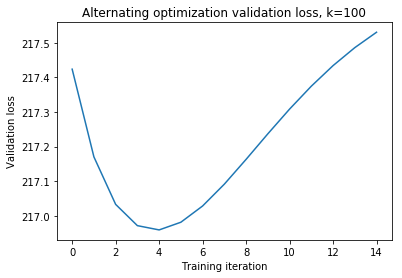

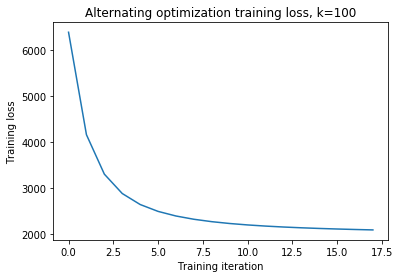

In [67]:
### YOUR PLOTTING CODE HERE ###
_ = plt.title('Alternating optimization validation loss, k=100')
_ = plt.xlabel('Training iteration')
_ = plt.ylabel('Validation loss')
_= plt.plot(val_l_a[4:])
plt.figure()
_ = plt.title('Alternating optimization training loss, k=100')
_ = plt.xlabel('Training iteration')
_ = plt.ylabel('Training loss')
_= plt.plot(tr_l_a[1:])

b) (**Optional**): Try some different latent dimensions $k$ in the range [5, 100]. What do you observe (convergence time, final training/validation losses)?

In [63]:
Q_a_2, P_a_2, val_l_a_2, tr_l_a_2, conv_a_2 = latent_factor_alternating_optimization(M_shifted, nonzero_indices, 
                                                                           k=20, val_idx=val_idx,
                                                                           val_values=val_values_shifted, 
                                                                           reg_lambda=0.1, init='random',
                                                                           max_steps=100, patience=10)

iteration 0, training loss: 92289.63, validation loss: 230.430447837
iteration 1, training loss: 70947.9378945, validation loss: 229.601751352
iteration 2, training loss: 61016.8675789, validation loss: 229.97156333
iteration 3, training loss: 54476.725893, validation loss: 232.257425706
iteration 4, training loss: 49734.7207348, validation loss: 233.336443688
iteration 5, training loss: 46129.7319267, validation loss: 233.945523527
iteration 6, training loss: 43271.1743904, validation loss: 234.011612508
iteration 7, training loss: 40940.6475732, validation loss: 234.034019873
iteration 8, training loss: 39006.3545495, validation loss: 234.192421151
iteration 9, training loss: 37377.437383, validation loss: 234.362471162
iteration 10, training loss: 35989.3731891, validation loss: 234.559480635
Converged after 1 iterations, on average 29.0635489767248 per iteration.


#### Plot the validation and training losses over (training) time

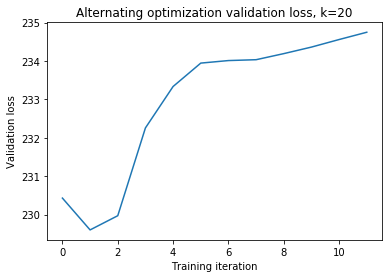

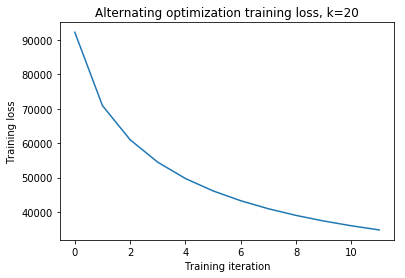

In [69]:

### YOUR PLOTTING CODE HERE ###
_ = plt.title('Alternating optimization validation loss, k=20')
_ = plt.xlabel('Training iteration')
_ = plt.ylabel('Validation loss')
_= plt.plot(val_l_a_2)
plt.figure()
_ = plt.title('Alternating optimization training loss, k=20')
_ = plt.xlabel('Training iteration')
_ = plt.ylabel('Training loss')
_= plt.plot(tr_l_a_2)

## 4. Latent factorization using gradient descent

We now use gradient descent to factorize our ratings matrix. We will try both (mini-) batch and stochastic gradient descent. You can use the following equations for your implementation.

Recall that the objective function (loss) we wanted to optimize was:
$$
\mathcal{L} = \min_{P, Q} \sum_{(x, i) \in W} (r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)^2 + \lambda_1\sum_x{\left\lVert \mathbf{p}_x  \right\rVert}^2 + \lambda_2\sum_i {\left\lVert\mathbf{q}_i  \right\rVert}^2
$$

where $W$ is the set of $(x, i)$ pairs for which $r_{xi}$ is known (in this case our known play counts). Here we have also introduced two regularization terms to help us with overfitting where $\lambda_1$ and $\lambda_2$ are hyper-parameters that control the strength of the regularization.

Naturally optimizing with gradient descent involves computing the gradient of the loss function $\mathcal{L}$ w.r.t. to the parameters. To help you solve the task we provide the following:

$$
\frac{\partial ((r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)^2)}{\partial \mathbf{p}_x} = -2(r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)\mathbf{q}_i\;, ~~~
\frac{\partial ((r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)^2)}{\partial \mathbf{q}_i} = -2(r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)\mathbf{p}_x 
$$

$$
\frac{\partial(\lambda_1{\left\lVert \mathbf{p}_x \right\rVert}^2)}{\partial \mathbf{p}_x} = 2 \lambda_1 \mathbf{p_x} \;, ~~~
\frac{\partial(\lambda_2{\left\lVert \mathbf{q}_i \right\rVert}^2)}{\partial \mathbf{q}_i} = 2 \lambda_2 \mathbf{q_i}
$$

**Hint**: You have to carefully consider how to combine the given partial gradients depending
on which variants of gradient descent you are using.  
**Hint 2**: It may be useful to scale the updates to $P$ and $Q$ by $\frac{1}{batch\_size}$ (in the case of full-sweep updates, this would be $\frac{1}{n\_users}$ for $Q$ and $\frac{1}{n\_restaurants}$ for $P$).


For each of the gradients descent variants you try report and compare the following:
* How many iterations do you need for convergence.
* Plot the loss (y axis) for each iteration (x axis).


In [71]:
def latent_factor_gradient_descent(M, non_zero_idx, k, val_idx, val_values, 
                                   reg_lambda, learning_rate, batch_size=-1,
                                   max_steps=50000, init='random',
                                   log_every=1000, patience=20,
                                   eval_every=50):
    """
    Perform matrix factorization using gradient descent. Training is done via patience,
    i.e. we stop training after we observe no improvement on the validation loss for a certain
    amount of training steps. We then return the best values for Q and P oberved during training.
    
    Parameters
    ----------
    M                 : sp.spmatrix, shape [N, D]
                        The input matrix to be factorized.
                      
    non_zero_idx      : np.array, shape [nnz, 2]
                        The indices of the non-zero entries of the un-shifted matrix to be factorized. 
                        nnz refers to the number of non-zero entries. Note that this may be different
                        from the number of non-zero entries in the input matrix M, e.g. in the case
                        that all ratings by a user have the same value.
    
    k                 : int
                        The latent factor dimension.
    
    val_idx           : tuple, shape [2, n_validation]
                        Tuple of the validation set indices.
                        n_validation refers to the size of the validation set.
                      
    val_values        : np.array, shape [n_validation, ]
                        The values in the validation set.
                      
    reg_lambda        : float
                        The regularization strength.

    learning_rate     : float
                        Step size of the gradient descent updates.
                        
    batch_size        : int, optional, default: -1
                        (Mini-) batch size. -1 means we perform standard full-sweep gradient descent.
                        If the batch size is >0, use mini batches of this given size.
                        
    max_steps         : int, optional, default: 100
                        Maximum number of training steps. Note that we will stop early if we observe
                        no improvement on the validation error for a specified number of steps
                        (see "patience" for details).
                      
    init              : str in ['random', 'svd'], default 'random'
                        The initialization strategy for P and Q. See function initialize_Q_P for details.
    
    log_every         : int, optional, default: 1
                        Log the training status every X iterations.
                    
    patience          : int, optional, default: 10
                        Stop training after we observe no improvement of the validation loss for X evaluation
                        iterations (see eval_every for details). After we stop training, we restore the best 
                        observed values for Q and P (based on the validation loss) and return them.
                      
    eval_every        : int, optional, default: 1
                        Evaluate the training and validation loss every X steps. If we observe no improvement
                        of the validation error, we decrease our patience by 1, else we reset it to *patience*.
                        
    Returns
    -------
    best_Q            : np.array, shape [N, k]
                        Best value for Q (based on validation loss) observed during training
                      
    best_P            : np.array, shape [k, D]
                        Best value for P (based on validation loss) observed during training
                      
    validation_losses : list of floats
                        Validation loss for every evaluation iteration, can be used for plotting the validation
                        loss over time.
                        
    train_losses      : list of floats
                        Training loss for every evaluation iteration, can be used for plotting the training
                        loss over time.                     
    
    converged_after   : int
                        it - patience*eval_every, where it is the iteration in which patience hits 0,
                        or -1 if we hit max_steps before converging. 

    """
       
    ### YOUR CODE HERE ###
            
    return best_Q, best_P, validation_losses, train_losses, converged_after

#### Train the latent factor model with alternating optimization.

a) Learn the optimal $P$ and $Q$ using standard gradient descent. That is, during each iteration you have to use all of the training examples and update $Q$ and $P$ for all users and songs at once. Try the algorithm with $k=30$, $\lambda=1$, and learning rate of 0.1. Initialize $Q$ and $P$ with SVD.  

In [73]:
Q_g_sweep, P_g_sweep, val_l_g_sweep, tr_l_g_sweep, conv_g_sweep =  latent_factor_gradient_descent(M_shifted, nonzero_indices, 
                                                                                                   k=30, val_idx=val_idx,
                                                                                                   val_values=val_values_shifted, 
                                                                                                   reg_lambda=1, learning_rate=1e-1,
                                                                                                   init='svd', batch_size=-1,
                                                                                                   max_steps=10000, log_every=20, 
                                                                                                   eval_every=20)

Iteration 0, training loss: 328658.640, validation loss: 280.312
Iteration 20, training loss: 318509.796, validation loss: 278.642
Iteration 40, training loss: 311356.150, validation loss: 278.041
Iteration 60, training loss: 305774.599, validation loss: 277.817
Iteration 80, training loss: 301172.643, validation loss: 277.777
Iteration 100, training loss: 297247.320, validation loss: 277.854
Iteration 120, training loss: 293820.770, validation loss: 278.018
Iteration 140, training loss: 290778.520, validation loss: 278.248
Iteration 160, training loss: 288042.048, validation loss: 278.530
Iteration 180, training loss: 285554.932, validation loss: 278.850
Iteration 200, training loss: 283275.162, validation loss: 279.201
Iteration 220, training loss: 281170.564, validation loss: 279.574
Iteration 240, training loss: 279215.916, validation loss: 279.962
Iteration 260, training loss: 277391.056, validation loss: 280.361
Iteration 280, training loss: 275679.601, validation loss: 280.766
I

#### Plot the validation and training losses over (training) time

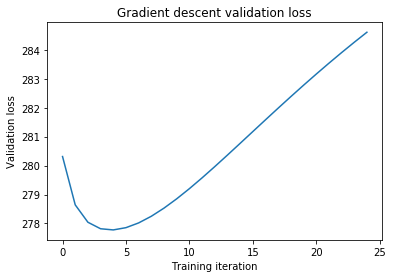

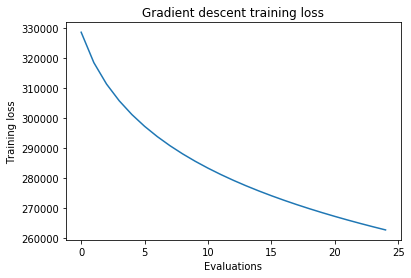

In [75]:

### YOUR PLOTTING CODE HERE ###


b) Learn the optimal $P$ and $Q$ using the original stochastic gradient descent (mini-batches of size 1). That is, during each iteration you sample a single random training example $r_{xi}$ and update only the respective affected parameters $\mathbf{p_x}$ and $\mathbf{q}_i$. Set the learning rate to 0.01 and keep the other parameters as in a).

In [63]:
Q_g_st, P_g_st, val_l_g_st, tr_l_g_st, conv_g_st = latent_factor_gradient_descent(M_shifted, nonzero_indices, 
                                                                                   k=30, val_idx=val_idx,
                                                                                   val_values=val_values_shifted, 
                                                                                   reg_lambda=1, learning_rate=1e-2,
                                                                                   init='svd', batch_size=1,
                                                                                   max_steps=20000, log_every=500, 
                                                                                   eval_every=50)

Iteration 0, training loss: 328658.640, validation loss: 280.312
Iteration 500, training loss: 328466.473, validation loss: 280.202
Iteration 1000, training loss: 328388.069, validation loss: 280.004
Iteration 1500, training loss: 328301.928, validation loss: 280.164
Iteration 2000, training loss: 328110.290, validation loss: 279.931
Iteration 2500, training loss: 328127.182, validation loss: 279.892
Iteration 3000, training loss: 328025.989, validation loss: 279.177
Iteration 3500, training loss: 327973.111, validation loss: 279.238
Converged after 3000 iterations, on average 0.015s per iteration


#### Plot the validation and training losses over (training) time

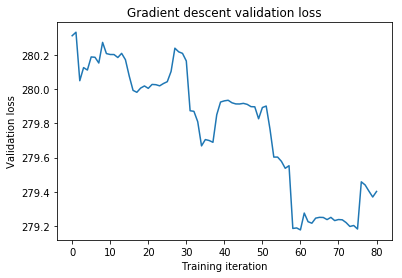

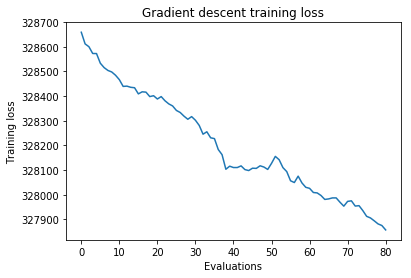

In [77]:

### YOUR PLOTTING CODE HERE ###


c) (**Optional**) Learn the optimal $P$ and $Q$ similarly to b) this time using larger mini-batches of size $S$, e.g. 32.

In [80]:
Q_g_mb, P_g_mb, val_l_g_mb, tr_l_g_mb, conv_g_mb = latent_factor_gradient_descent(M_shifted, nonzero_indices, 
                                                                                   k=30, val_idx=val_idx,
                                                                                   val_values=val_values_shifted, 
                                                                                   reg_lambda=1, learning_rate=1e-1,
                                                                                   init='svd', batch_size=32,
                                                                                   max_steps=10000, log_every=100, 
                                                                                   eval_every=50)

Iteration 0, training loss: 328658.640, validation loss: 280.312
Iteration 100, training loss: 328198.817, validation loss: 279.981
Iteration 200, training loss: 327811.778, validation loss: 279.962
Iteration 300, training loss: 327484.019, validation loss: 280.228
Iteration 400, training loss: 327233.180, validation loss: 279.921
Iteration 500, training loss: 326955.409, validation loss: 279.862
Iteration 600, training loss: 326755.455, validation loss: 279.484
Iteration 700, training loss: 326466.317, validation loss: 279.271
Iteration 800, training loss: 326288.477, validation loss: 279.261
Iteration 900, training loss: 326107.337, validation loss: 279.213
Iteration 1000, training loss: 325937.267, validation loss: 278.889
Iteration 1100, training loss: 325769.050, validation loss: 279.033
Iteration 1200, training loss: 325549.652, validation loss: 279.016
Iteration 1300, training loss: 325258.222, validation loss: 279.059
Iteration 1400, training loss: 325112.294, validation loss: 

#### Plot the validation and training losses over (training) time

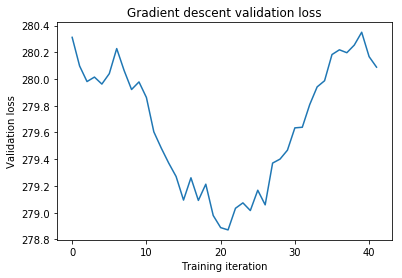

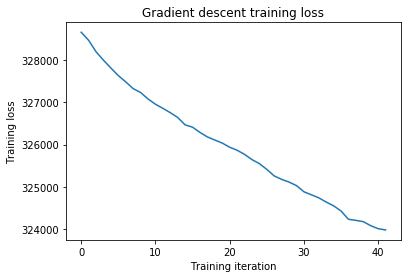

In [90]:

### YOUR PLOTTING CODE HERE ###


### 4.5 Hyperparameter search

Machine learning models are often heavily dependent on the hyperparameter settings, e.g. the learning rate. Here, we will try a simple random search to find good values of the latent factor dimension $k$, the batch size, learning rate, and regularization.  

### Tasks:

Perform a hyperparameter search to find good values for the batch size, lambda, learning rate, and latent dimension. 

* For the batch size, evaluate all values in [1, 32, 512, -1] (-1 corresponds to full-sweep gradient descent).
* For $\lambda$, randomly sample three values in the interval [0, 1).
* For the learning rate, evaluate all values in [1, 0.1, 0.01].
* For the latent dimension, uniformly sample three values in the interval [5,30].

Perform an exhaustive search among all combinations of these values;

**Hint**: This may take a while to compute. **You don't have to wait for all the models to train** -- simply use "dummy" code instead of actual model training (or let it train, e.g., for only one iteration) if you don't want to wait. Note that the signature of this dummy code has to match the function 'latent_factor_gradient_descent' so that we could simply plug in the actual function.



In [56]:
def parameter_search(M_train, val_idx, val_values):
    """
    Hyperparameter search using random search.
    
    Parameters
    ----------
    
    M_train     : sp.spmatrix, shape [N, D]
                  Input sparse matrix where the user means have not
                  been subtracted yet. 
                  
    val_idx     : tuple, shape [2, n_validation]
                  The indices used for validation, where n_validation
                  is the size of the validation set.
                  
    val_values  : np.array, shape [n_validation, ]
                  Validation set values, where n_validation is the
                  size of the validation set.

    Returns
    -------
    best_conf   : tuple, (batch_size, lambda, learning_rate, latent_dimension)
                  The best-performing hyperparameters.
                  

    """
    
    ### YOUR CODE HERE ###
        
    print("Best configuration is {}").format(best_conf)
    return best_conf
    

In [57]:
best_configuration = parameter_search(M_train, val_idx, val_values)

Training with configuration XXXXXX
Iteration 0, training loss: 1071956.651, validation loss: 719.310
Iteration 500, training loss: 493893.602, validation loss: 346.959
Iteration 1000, training loss: 408957.930, validation loss: 303.637
Iteration 1500, training loss: 376618.216, validation loss: 274.038
Iteration 2000, training loss: 357794.035, validation loss: 263.592
Iteration 2500, training loss: 346281.738, validation loss: 258.203
Iteration 3000, training loss: 339640.868, validation loss: 255.034
Iteration 3500, training loss: 334285.694, validation loss: 251.957
Iteration 4000, training loss: 330670.072, validation loss: 250.495
Done. Best validation loss 247.37486658324315
New best configuration: XXXXXX

Training with configuration XXXXXX
Iteration 0, training loss: 17110555.962, validation loss: 12041.793
Iteration 500, training loss: 1397664.400, validation loss: 1086.769
Iteration 1000, training loss: 782314.657, validation loss: 544.107
Iteration 1500, training loss: 573700

#### Output the best hyperparameter optimization

In [84]:

### YOUR CODE HERE ###


Best batch size: XX
Best lambda: XX
Best learning rate: XX
Best latent dimension: XX


## 5. Comparison of gradient descent and alternating optimization

After training the latent factor model with both alternating optimization and gradient descent, we now compare their results on the training, validation, and test set.

### Tasks

* Compare the root mean square errors (RMSE) for the training, validation, and test sets different settings of $k$ for both alternating optimization and gradient descent. What do you observe?
* Compare the test RMSE for the alternating optimization model and the gradient descent model. Which performs better?
* Plot the predicted ratings

**Hint**: The output values and plots below are the ones we got when testing this sheet. Yours may be different, but if your validation or test RMSE values are larger than 1.5 or 2, it is likely that you have a bug in your implementation.

In [82]:

### YOUR CODE HERE ###


Training RMSE of best gradient descent model: 0.9072827022547377
Validation RMSE of best gradient descent model: 1.1929069043058236
Test RMSE of best gradient descent model: 1.103840236022863


In [83]:

### YOUR CODE HERE ###


Training RMSE of best gradient descent model: 0.08577585625314868
Validation RMSE of best gradient descent model: 1.2087560109547064
Test RMSE of best gradient descent model: 1.1307052375638196


#### Plots: Prediction vs. ground truth ratings

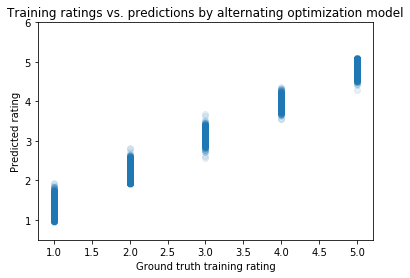

In [85]:

### YOUR PLOTTING CODE HERE ###


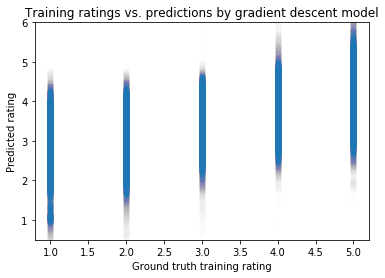

In [87]:

### YOUR PLOTTING CODE HERE ###


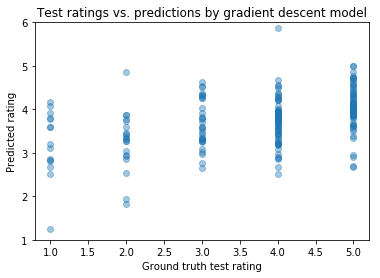

In [88]:

### YOUR PLOTTING CODE HERE ###


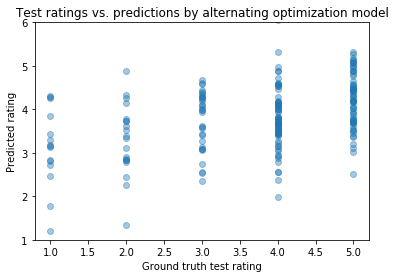

In [89]:

### YOUR PLOTTING CODE HERE ###
